In [1]:
# Enter your API key for ChatGPT
# import os
# os.environ["OPENAI_API_KEY"] = "Enter your API key here."
# Or alternatively save your OPENAI key in a .env file and load it via dotenv
from dotenv import load_dotenv
load_dotenv()
import scllm as sl
import scanpy as sc
import pandas as pd
from langchain_openai import ChatOpenAI

import warnings
warnings.filterwarnings("ignore")

# Annotate cell types

## PBMC dataset


In this tutorial we will use Chat GPT to annotate cell types.

In [2]:
pbmc = sc.datasets.pbmc3k_processed()

In [3]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

In [4]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
sc.tl.leiden(pbmc, flavor="igraph", n_iterations=2)

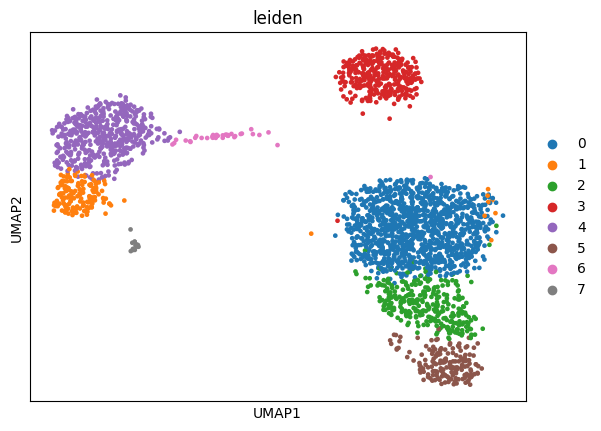

In [6]:
sc.pl.umap(pbmc, color='leiden')

To annotate the cells we simply use the `annotate_cluster` function. This will iterate through each cluster and try to determine the most likely cell types.

In [10]:
sl.tl.annotate_cluster(pbmc, 'leiden', llm, use_raw=True, top_genes=30, num_samples=4)

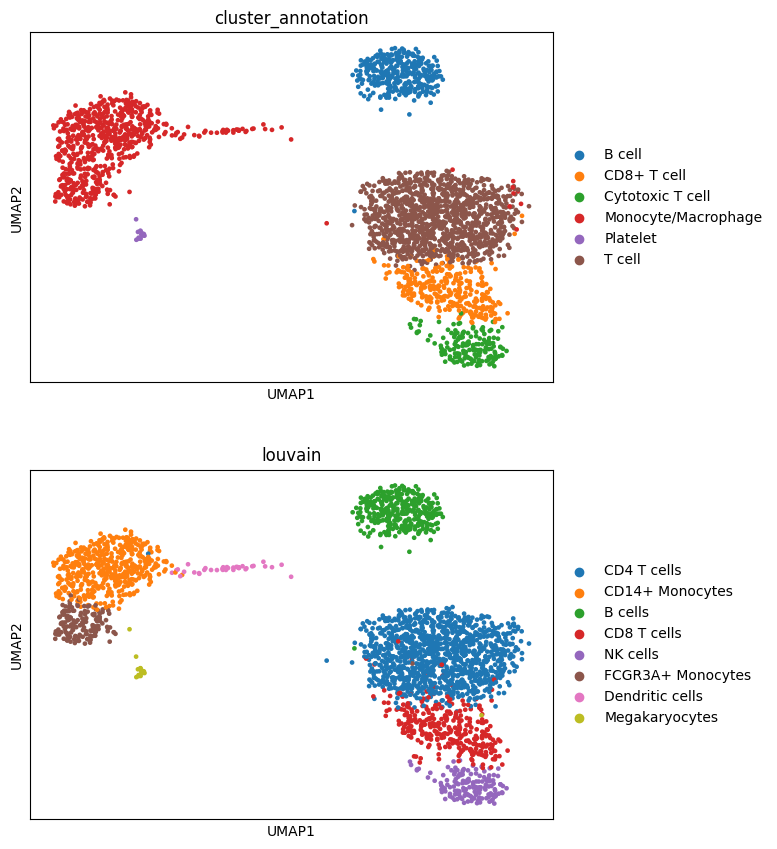

In [11]:
sc.pl.umap(pbmc, color=['cluster_annotation', 'louvain'], ncols=1)

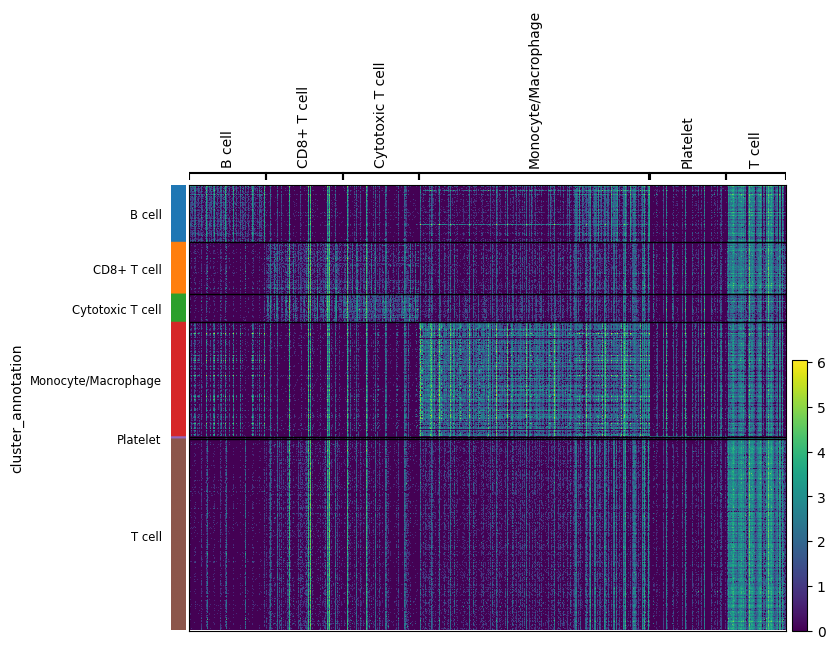

In [12]:
sc.pl.heatmap(pbmc, var_names=pbmc.uns['cluster_annotation']['var_names'], groupby='cluster_annotation')

## Angelidis

In this example we will use the `annotate_cluster` function to annotate the cells in the Angelidis dataset.

In [9]:
angelidis = sc.read_h5ad('/Users/harald/Downloads/umap_1.h5ad')

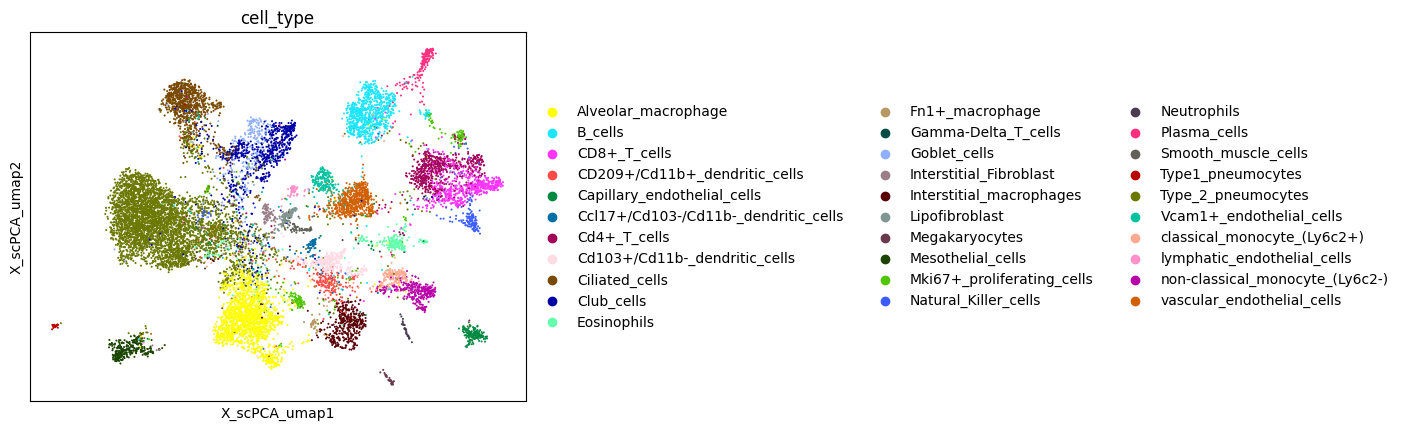

In [10]:
sc.pl.embedding(angelidis, 'X_scPCA_umap', color='cell_type')

In [11]:
sc.tl.leiden(angelidis, flavor="igraph", n_iterations=2, neighbors_key='X_scPCA')

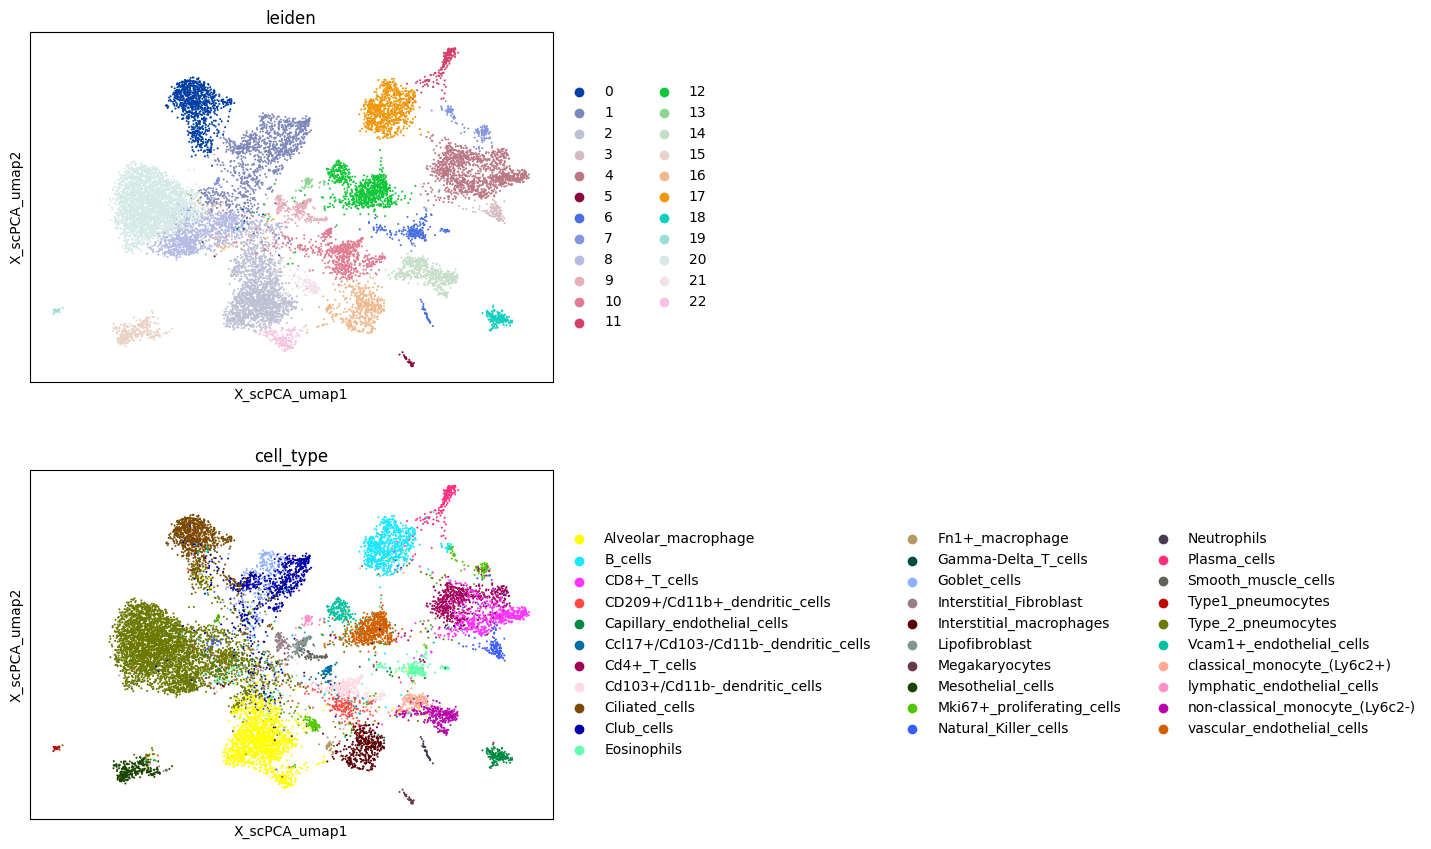

In [12]:
sc.pl.embedding(angelidis, basis='X_scPCA_umap', color=['leiden', 'cell_type'], ncols=1)

In [13]:
angelidis.layers['log1p'] = sc.pp.log1p(angelidis.layers['counts'])

In [14]:
sl.tl.annotate_cluster(
    angelidis, 
    'leiden', 
    llm, 
    top_genes=30, 
    num_samples=20, 
    extra="Keep in mind that cells stem from lung tissue.", 
    layer='log1p', 
    method='wilcoxon'
    )

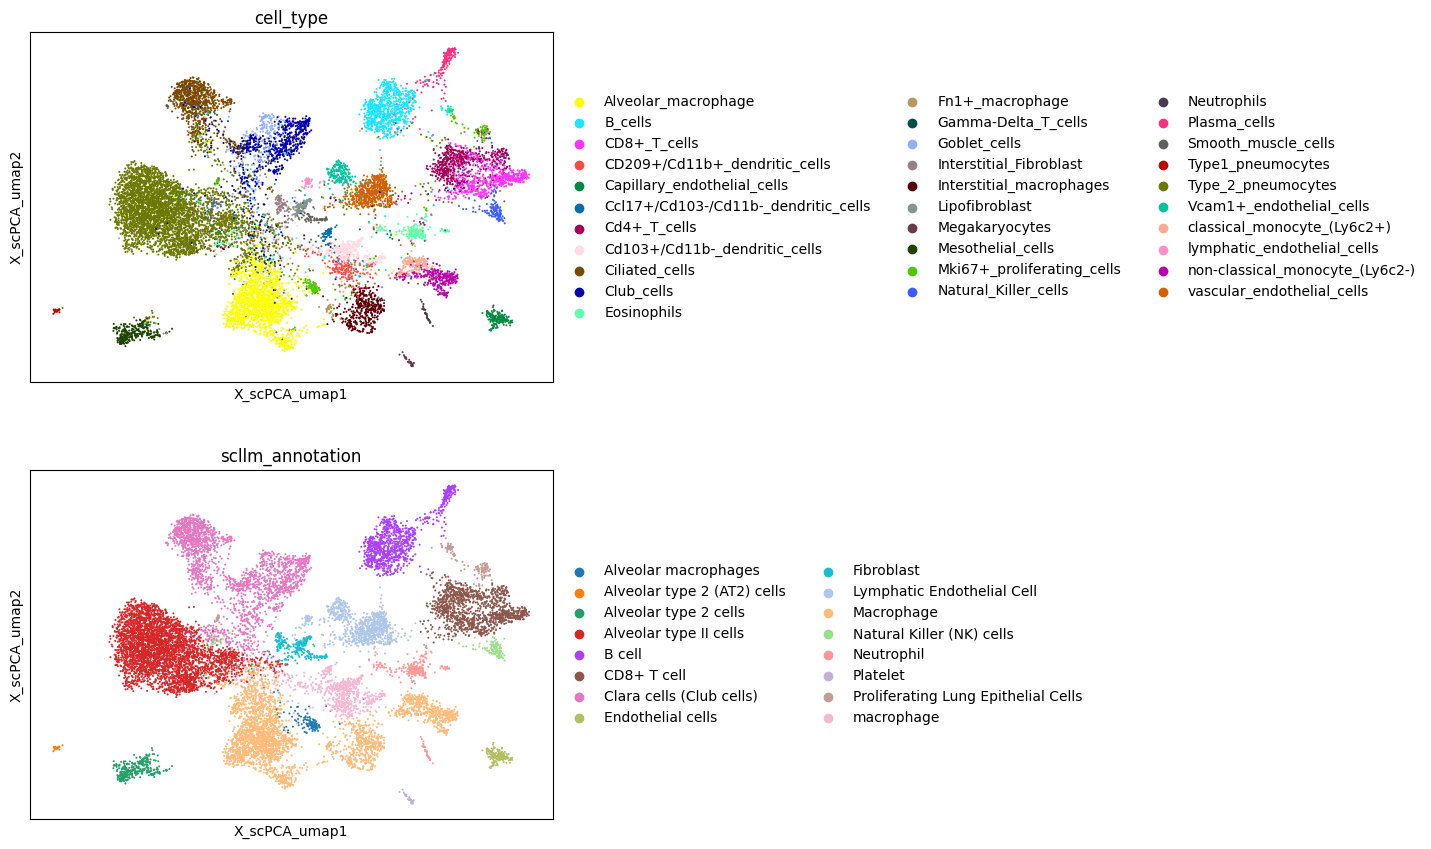

In [15]:
sc.pl.embedding(angelidis, basis='X_scPCA_umap', color=['cell_type', 'scllm_annotation'], ncols=1)

In [16]:
sl.tl.annotate_cluster(
    angelidis, 
    'leiden', 
    llm, 
    top_genes=50, 
    num_samples=10, 
    key_added='alternative_annotation',
    layer='log1p', 
    method='wilcoxon'
    )

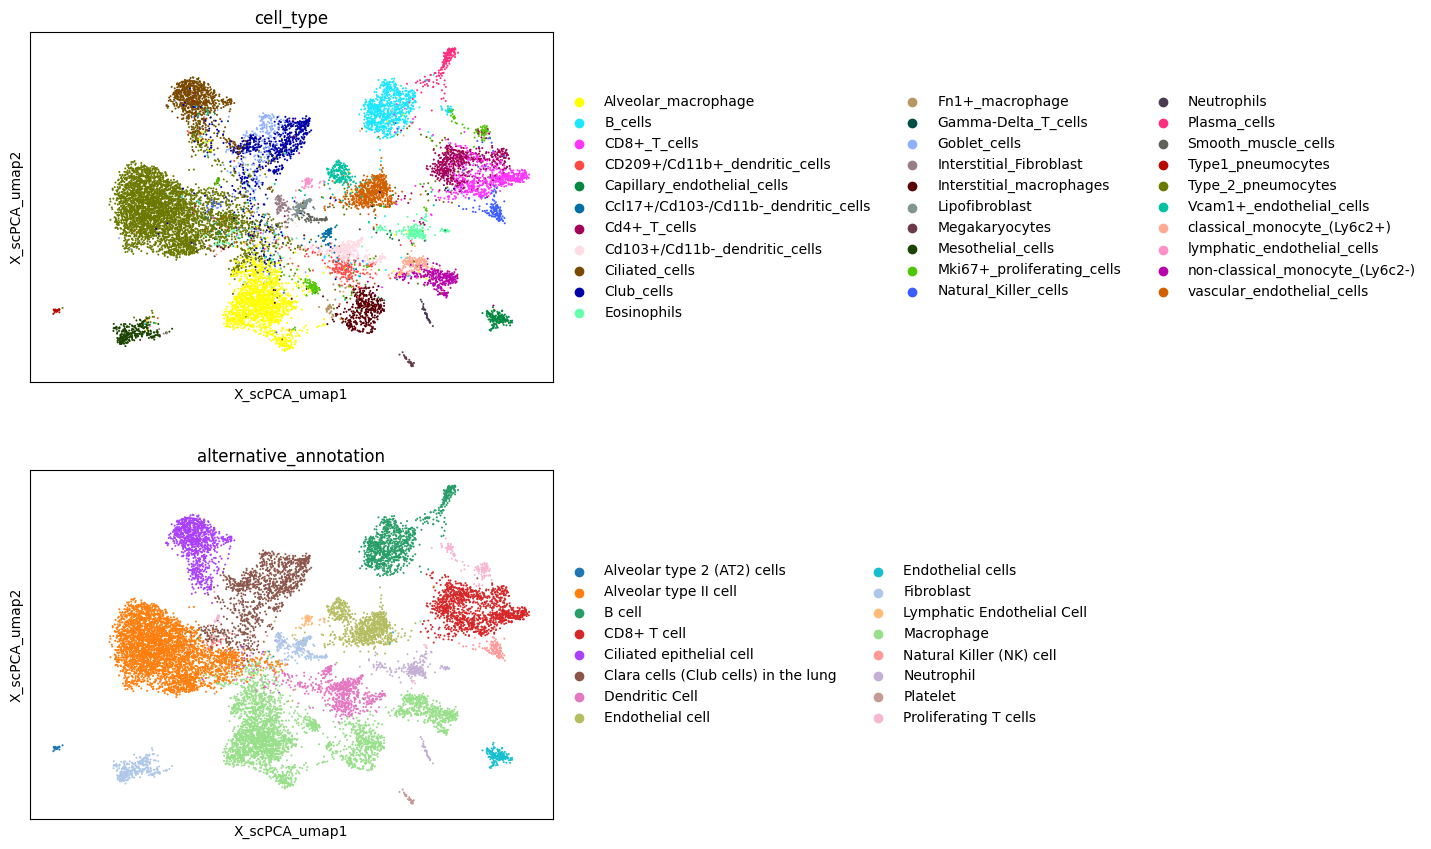

In [17]:
sc.pl.embedding(angelidis, basis='X_scPCA_umap', color=['cell_type', 'alternative_annotation'], ncols=1)